# Regresja Logistyczna

W tym zadaniu zajmiemy się klasyfikowaniem zdjęć kotów - do tego celu użyjemy zbioru zawierającego zdjęcia kotów i "całej reszty". Pomimo nazwy regresja logistyczna jest częściej używana do zadania klasyfikacji niż regresji. Ten model jest również bardzo ważnym elementem składowym sieci neuronowych - dlatego właśnie zajmiemy się nim w szczegółach. <br> 
Na wstępie zaznaczę ważną różnicę modelu regresji logistycznej od regresji liniowej - **trenowanie regresji liniowej polegało na analitycznym wyliczeniu parametrów modelu. Tak naprawdę jest to wyjątek - praktycznie w żadnym innym modelu nie potrafimy wyznaczyć parametrów w sposób analityczny. Dlatego, jak zaraz zobaczymy w regresji logistycznej, będziemy starali się iteracyjnie docierać do minimum ustalonej funkcji kosztu**.

## Ściągnięcie bibliotek i danych

In [ ]:

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
import tensorflow as tf
import itertools
import cv2
import random
import urllib
from utils import decrypt_pickle, SelectFilesButton, bcolors
# random.seed(42)


#### Ściągnięcie danych

In [ ]:
#PROSZĘ NAJPIERW ŚCIĄGNĄĆ DANE: https://drive.google.com/drive/folders/1toYvTcvTzhcpeXvcAbO9M1xbBv2ruA5a?usp=sharing
#proszę zmienić wartość `password` na wartość podaną podczas zajęć
all_data = decrypt_pickle('catvsnotcat.pkl.aes', password=None)

Dane mają formę listy zawierającej 10 000 słowników - każdy słownik ma klucz 'X' ze zdjęciem w formie macierzy numpy oraz klucz 'Y' ze stringiem "cat" lub "not-cat". Zobaczmy kilka przykładów zdjęć ze zbioru

In [ ]:

fig, axes = plt.subplots(nrows=4,ncols=3, figsize=(18,12))
axes = axes.flatten()
number_of_examples = len(all_data)
for idx, axis in enumerate(axes):
    idx = random.randint(0, number_of_examples)
    example = all_data[idx]
    axis.axis('off')
    axis.set_title(f"{example['Y']}")
    axis.imshow(example['X'])

W poniżej komórce przeskalujemy wszystkie zdjęcia do wymiaru 64x64. Użyjemy do tego biblioteki OpenCV. Ponadto zamienimy klasy "not-cat" i "cat" na odpowiednio wartości 0 i 1 - model może działać tylko na liczbach!<br>**Poniższa komórka może się wykonywać trochę czasu**

In [ ]:
IMG_SIZE = 64

number_of_examples = len(all_data)
let_know = int(number_of_examples / 10)
all_data_processed = []
label_dict = {'cat': 1, 'not-cat': 0}

for idx, example in enumerate(all_data):
    if (idx+1)%let_know == 0:
        print(f'processing {idx + 1}')
    resized_down = cv2.resize(example['X'], (IMG_SIZE, IMG_SIZE), interpolation= cv2.INTER_LINEAR)
    
    all_data_processed.append({'X': np.array(resized_down), 'Y': label_dict[example['Y']]})

Ponownie zobaczmy kilka zdjęć naszego zbioru - są widocznie mniej wyraźne (mniejsza rozdzielczość) oraz wszystkie są kwadratowe (dlatego część może się wydawać nienaturalnie ściśniętych).

In [ ]:
classNames = ['not-cat', 'cat']
fig, axes = plt.subplots(nrows=2,ncols=3, figsize=(18,12))
axes = axes.flatten()
for axis in axes:
    idx = random.randint(0, number_of_examples)
    example = all_data_processed[idx]
    axis.axis('off')
    axis.set_title(classNames[example['Y']])
    axis.imshow(example['X'])

Wracając do kwestii overfittingu - aby w ogóle móc przeciwdziałać temu zagadnieniu musimy umieć go mierzyć. Nie tylko przez obserwację na wykersów, gdzie ocena jest subiektywna, ale przez ściśle zdefiniowane miary. Aby wykonywać to poprawnie dzieli się zbiór danych na trzy (lub dwa) podzbiory: <br>
**Zbiór treningowy** - zwykle największa część danych (między 60% a 99% całego zbioru w zależności od wielkości zbioru). To na nim trenujemy (optymalizujemy) nasz model. Najczęściej, po treningu, to właśnie na nim nasze miary będą najlepsze. <br>
**Zbiór walidacyjny** - (między 20% a 1% całego zbioru) służy do wyboru najlepszego modelu jeśli trenujemy kilka modeli na raz (np. z różnymi hiperparametrami). Czasem jest pomijany jeśli nie generujemy kilku modeli - tak też będzie w naszym zadaniu. <br>
**Zbiór testowy** - (między 30% a 1% całego zbioru) to na nim sprawdzamy jakość naszego modelu. Jeśli chcemy komunikować "na zewnątrz" miary to właśnie wyliczone na nim. 
<br><br>
Warto tutaj przywołać jedną z ideii ML: **Tworząc model i trenując go na danych treningowych liczymy na to (dążymy do tego), że na danych testowych będzie on się zachowywał tak samo dobrze lub minimalnie gorzej**<br>
Ponieważ czasem zbiór danych zawiera pewną informację/strukturę w kolejności (np. wpierw są tylko zdjęcia kotów a potem tylko psób) bardzo dobrym nawykiem jest losowe przemieszanie danych.<br>
##### Proszę losowo przemieszać listę *all_data_processed*, najlepiej za pomocą biblioteki random

In [ ]:
random.seed(42)
# proszę kontynuować kod


In [ ]:
#rozwiązanie
random.seed(42)
random.shuffle(all_data_processed)

In [ ]:
X = np.array([example['X'] for example in all_data_processed])
Y = np.array([example['Y'] for example in all_data_processed])
print(f"{bcolors.BOLD}Rozmiar cech (X): {X.shape}, rozmiar flagi/indykatora klasy (Y): {Y.shape}{bcolors.ENDC}")

Proszę zwrócić uwagę na rozmiar macierzy X - 1000 (lub inna liczbe jeśli zostało wzięte więcej zdjęć) odpowiada za liczbę zdjęć, wszystkie zdjęcia ściągneliśmy do rozmiary 64x64 za pomocą biblioteki openCV, **zaś ostatni wymiar z liczbą 3 odpowiada za kanały koloru RGB - tak naprawdę plik zdjęcia jest macierzą width x height x color_channels**. My, aby ułatwić sobie w tym momencie zadanie, rozplączemy to wszystko jaki jeden wektor długości $12288$ ($64\cdot64\cdot3$) i tym samym "zapomnimy" o strukturze danych.<br><br>
Sprawdźmy czy nasz zbiór jest zbalansowany - czy posiada porównywalną liczbę zdjęć psób i kotów:

In [ ]:
cat_count = np.sum(Y)
print(f"W naszym zbiorze znajduje się {cat_count} zdjęć kotów ({cat_count*100/len(Y):0.1f}%) i {len(Y) - cat_count} zdjęć bez kota ({100*(len(Y) - cat_count)/len(Y):0.1f}%)")

Po tych wszystkich analizach możemy w końcu podzielić nasze dane na zbiór treningowy i testowy.<br>
##### Proszę kontynuować kod i stworzyć podzbiory:

In [ ]:
split_ratio = 0.8
split_idx = int(len(Y)*split_ratio)
# proszę zadeklarować poniższe zmienne korzystając z macierzy X i Y (podpowiedź: slice):


Oczywiście tak powtarzalna fukcjonalność jest również zaimplementowana w popularnych bibliotekach: <br>
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# rozwiązanie
X_train = X[:split_idx,:,:,:]
X_test = X[split_idx:,:,:,:]
Y_train = Y[:split_idx]
Y_test = Y[split_idx:]

Teraz "rozplączemy" macierze zdjęć 64x64x3 na długie wektory:

In [ ]:
X_train = X_train.reshape(X_train.shape[0], -1).T
X_test = X_test.reshape(X_test.shape[0], -1).T
Y_train = Y_train.reshape((1, -1))
Y_test = Y_test.reshape((1, -1))

print ("X_train shape: " + str(X_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("Y_test shape: " + str(Y_test.shape))

Przyjrzyjmy się wartością pixeli (X_train) za pomocą histogramu:

In [ ]:
sns.histplot(X_train.flatten())

Kolejną dobrą praktyką jest normalizacja (lub standaryzacja danych). Powyższy wykres pokazał nam, że dane znajdują się w przedziale 0 - 255, zatem wystarczy podzielić przez 255 aby każda wartość w X była z przedziału 0-1:

In [ ]:
X_train = X_train / 255.
X_test = X_test / 255.

## Elementy modelu regresji logistycznej

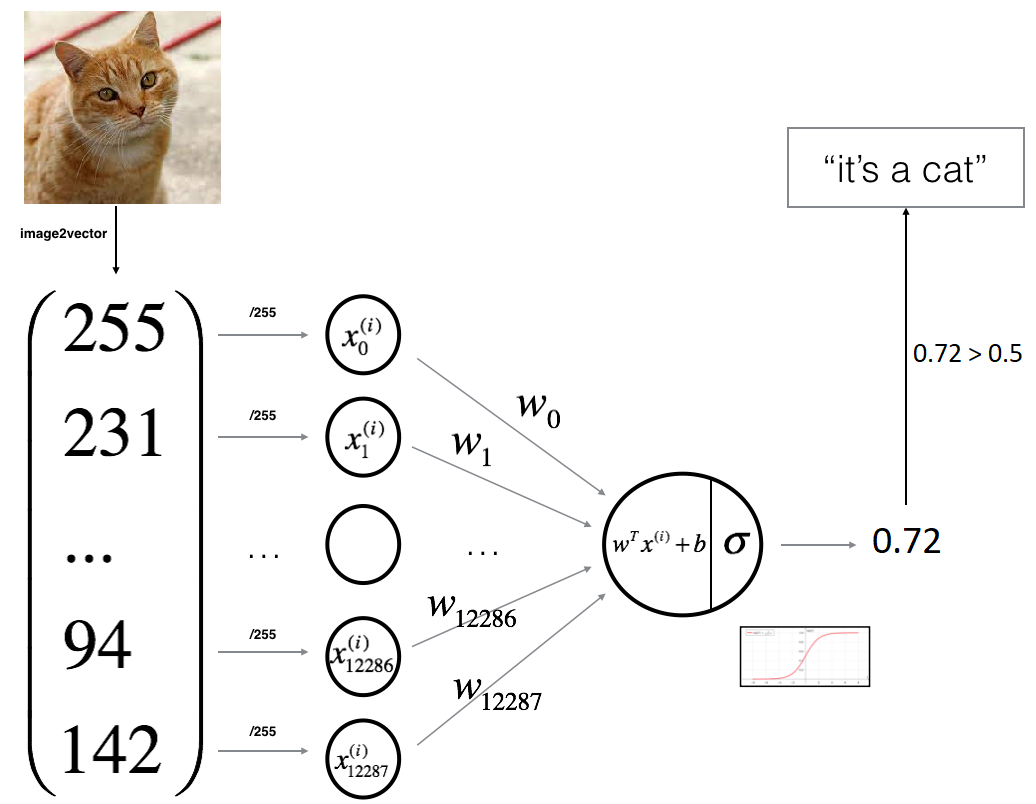

Powyżej przedstawiono objaśnienie jak będzie działał nasz model - zaczyanając od zdjęcia (już 64x64) i dochodząc do predykcji. Model regresji logistycznej tym również różni się od regresji liniowej, że używa funkcji aktywacji - tutaj sigmoidy - nałożonej właśnie na wyjście z regresji liniowej, dlatego notacja $w^T x^{(i)} + b$ powinna nam być już znajoma z poprzedniego zadnia. Poniżej wzory dla jednego zdjęcia oznaczonego *i*:

$$z^{(i)} = w^T x^{(i)} + b $$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})$$ 

W regresji logistycznej korzystamy także z innej funkcji kosztu (Log Loss):
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})$$

Zaś koszt dla wszystkich zdjęć obliczamy przez średnią ze wszystkich:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})$$


Tak jak wcześniej zaznaczyłem niestety nie potrafimy analitycznie wyznaczyć parametrów regresji logistycznej (*w* i *b*) analitycznie. Dlatego aby dojść do możliwie najlepszych parametrów będziemy wykonywać następującą procedurę (powtarzalną w większości modeli ML):

1. Zdefiniowanie struktury modelu (wejścia, wyjścia, funkcja kosztu, *inne hiperparametry*)
2. Losowe zainicjalizowanie parametrów modelu
3. Powtarzanie w pętli:
    - Wyliczenie aktualnego kosztu (dla aktualnych parametrów) - forward propagation
    - Wyliczenie gradientu kosztu - backward propagation
    - Zaktualizowanie parametrów za pomocą gradientu - gradient descent

Poniżej kilka "intuicji" dotyczących iteracyjnego docierania do minimum:

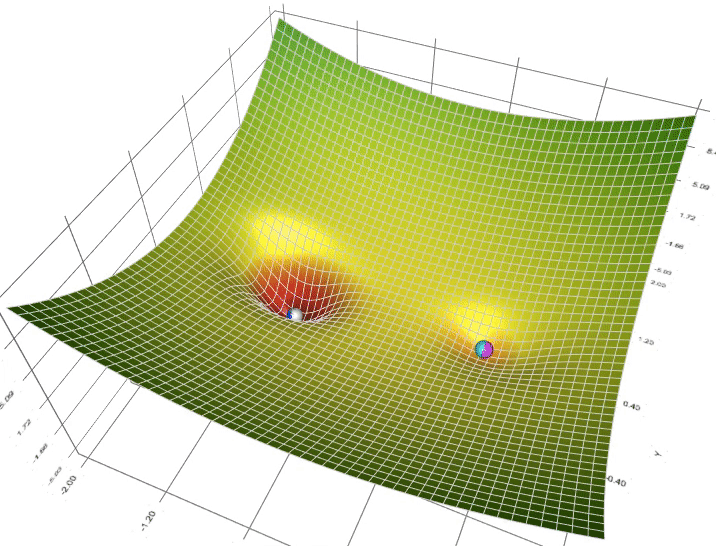

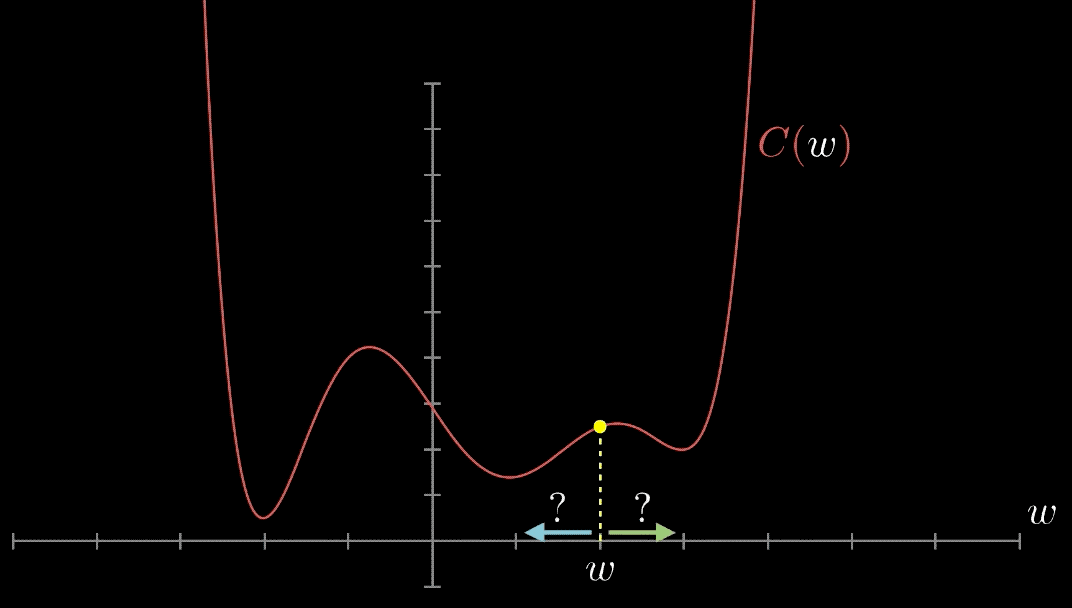

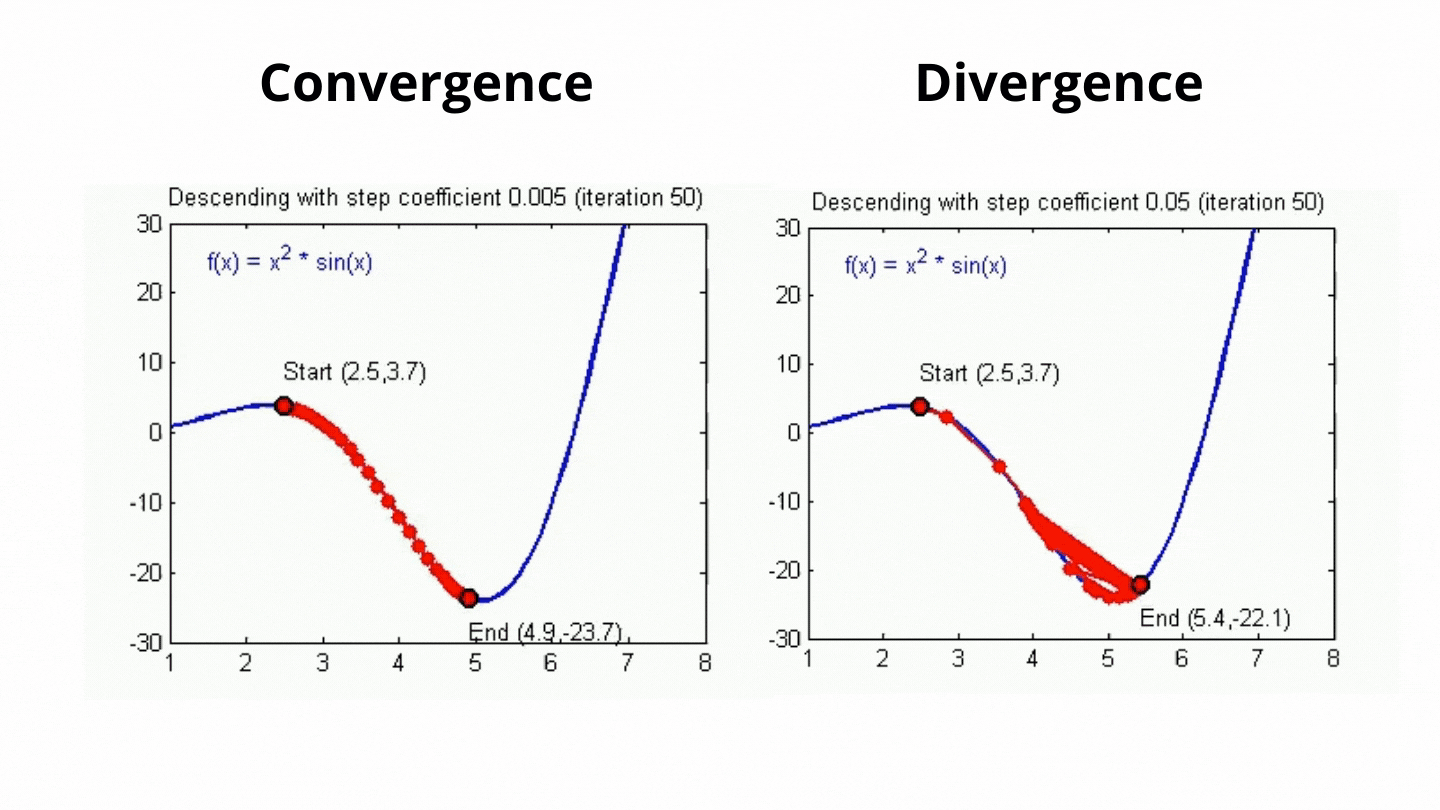

Poniżej kilka elementów, które potem zintegrujemy w model regresji logistycznej

##### Proszę uzupełnić definicję funkcji sigmoid:

In [ ]:
def sigmoid(z):
    """
    Wyliczyć wartość funkcji sigmoida z wartości z

    Argumenty:
    z -- liczba (skalar) lub numpy.array o dowolnych rozmiarach.

    Zwraca:
    s -- sigmoida(z)
    """

    ### Proszę poniżej uzupełnić kod ### (≈ 1 linijka kodu)
    
    ### Koniec uzupełniania kodu ###
    
    return s

In [ ]:
# rozwiązanie
def sigmoid(z):

    s = 1 / (1 + np.exp(-z))

    return s

In [ ]:
print (f"sigmoid(0) = {sigmoid(0)}")
print (f"sigmoid(4.2) = {sigmoid(9.2):.6}")

<span style="font-family:Monospace"> sigmoid(0) = 0.5 <br>
sigmoid(4.2) = 0.999899 </span>

In [ ]:
x_lin = np.linspace(-10, 10, 1000)
y_lin = sigmoid(x_lin)
half_lin = np.ones(y_lin.shape)*0.5
plt.plot(x_lin, y_lin)
plt.plot(x_lin, half_lin, c='red')
plt.grid()

plt.show()

##### Proszę uzupełnić funkcję inicjalizacji parametrów

Chodzi po prostu o to aby zainicjalizowane macierze *w* i *b* były odpowiednich rozmiarów. Dla regresji logistycznej zainicjalizujemy wszystko na wartość 0, **inaczej niż w sieciach neuronowych gdzie będziemy inicjalizować za pomocą liczby losowej**.

In [ ]:
def initialize_with_zeros(dim):
    """
    Funkcja generująca wektor zer o rozmiarze (dim, 1) dla parametru w i liczbę 0 dla parameru b.
    
    Argument:
    dim -- wymiarowość wektora w.
    
    Zwraca:
    w -- zainicjalizowany wektor o rozmiarze (dim, 1)
    b -- zainicjalizowany skalar (liczba)
    """
    
    ### Proszę poniżej uzupełnić kod ### (≈ 2 linijki kodu)
    
    ### Koniec uzupełniania kodu ###

    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

In [ ]:
# rozwiązanie
def initialize_with_zeros(dim):

    w = np.zeros(shape=(dim, 1))
    b = 0

    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

In [ ]:
dim = 3
w, b = initialize_with_zeros(dim)
print (f"w = {w}")
print (f"b = {b}")

<span style="font-family:Monospace"> w = [[0.] <br>
$\;$[0.] <br>
$\;$[0.]] <br>
b = 0</span>

Od razu warto zaznaczyć, że w naszym działającym przykładzie wymiarowość wektora $w$ będzie wynosić ($12288$, $1$) <br> ($12288 = 64\cdot64\cdot3$)

##### Proszę uzupełnić kod zawierający Forward propagation i Backward propagation

Czyli wyliczenie kosztu podczas propagacji wprzód i wyliczenie gradientu podczas propagacji wstecz. Do poniższej funkcji przydadzą się następujące informacje:

Forward Propagation:
- Na wejściu mamy macierz X
- Wyliczamy aktualną predykcję modelu (dla wszystkich $m$ przykładów) $A = \sigma(w^T X + b) = (a^{(0)}, a^{(1)}, ..., a^{(m-1)}, a^{(m)})$
- Wyliczamy aktualną wartość funkcji kosztu: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

Backward Propagation - na podstawie aktualnej funkcji kosztu wyliczamy gradient (pochodne cząstkowe) - te gradienty wskarzą nam w jaką stronę mamy podążać aby zmniejszać funkcję kosztu: 

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})$$

In [ ]:
def propagate(w, b, X, Y):
    """
    Zaimplementować funkcję kosztu i jej pochodne cząstkowe (jak opisano powżej)

    Argumenty:
    w -- wagi, wektor numpy.array o rozmiarze (szerokość_pikseli * wysokość_pikseli * 3, 1)
    b -- bias, liczba
    X -- dane o rozmaiarze (szerokość_pikseli * wysokość_pikseli * 3, liczba przykładów)
    Y -- flaga/klasa danych (0 jeśli kot, 1 jeśli pies) o rozmiarze (1, liczba przykładów)

    Zwaraca:
    cost -- koszt regresji logistycznej (negative log-likelihood)
    dw -- pochodna cząstkowa kosztu względem w (ma taki sam rozmiar jak w)
    db -- pochodna cząstkowa kosztu względem b (ma taki sam rozmiar jak b)
    """
    
    m = X.shape[1]
    
    # Forward Propagation (od X do kosztu)
    ### Proszę poniżej uzupełnić kod ### (≈ 2 linijki kodu)
                                                                # wyliczyć aktywację
                                                                # wyliczyć funkcję kosztu
    ### Koniec uzupełniania kodu ###
    
    # Backward Propagation (na podstawie kosztu policzyć gradient)
    ### Proszę poniżej uzupełnić kod ### (≈ 2 linijki kodu)
    
    ### Koniec uzupełniania kodu ###

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [ ]:
# rozwiązanie
def propagate(w, b, X, Y):

    m = X.shape[1]

    A = sigmoid(np.dot(w.T, X) + b)  # wyliczyć aktywację
    cost = (- 1 / m) * np.sum(Y * np.log(A) + (1 - Y) * (np.log(1 - A)))  # wyliczyć funkcję kosztu

    dw = (1 / m) * np.dot(X, (A - Y).T)
    db = (1 / m) * np.sum(A - Y)

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [ ]:
w, b, x, y = np.array([[4], [2]]), 1, np.array([[0,3], [1,2]]), np.array([[1, 0]])
grads, cost = propagate(w, b, x, y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

<span style="font-family:Monospace"> dw = [[1.49999994] <br>
$\;$[0.97628702]] <br>
db = 0.4762870427115289 <br>
cost = 8.52429369503258</span>

##### Optymalizacja
Przypomnijmy sobie co już mamy gotowe
- Zainicjowaliśmy parametry.
- Posiadamy już funkcję do wyliczania kosztu i gradientu.
- Zatem teraz na tej podstawie będziemy aktualizować parametry.

Do powyższej zdefiniowanego zadania potrzebujemy jeszcze znać liczbę powtórzeń - num_iterations, nazywana też epokami w ML oraz kroku uczenia (learning rate) - czyli jak bardzo będziemy się poruszali w stronę wyznaczonego gradientu.

Wzory do aktulizacji parametrów: $$ w = w - \alpha \text{ } dw$$ $$ b = b - \alpha \text{ } db$$ gdzie $\alpha$ jest krokiem uczenia.

In [ ]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    Funkcja optymalizująca parametry w i b poprzez aplikowanie pochodnej cząstkowej (gradient descent algorithm).
    
    Argumenty:
    w -- wagi, wektor numpy.array o rozmiarze (szerokość_pikseli * wysokość_pikseli * 3, 1)
    b -- bias, liczba
    X -- dane o rozmaiarze (szerokość_pikseli * wysokość_pikseli * 3, liczba przykładów)
    Y -- flaga/klasa danych (0 jeśli kot, 1 jeśli pies) o rozmiarze (1, liczba przykładów)
    num_iterations -- liczba powtórzeń pętli
    learning_rate -- krok uczenia w aktualizowaniu parametrów
    print_cost -- jeśli podamy True to co 100 epok (powtórzeń) będzie wypisywana informacja
    
    Zwraca:
    params -- słownik zawierający parametry w i b
    grads -- słownik zawierający pochodne cząstkowe funkcji kosztu względem w i b
    costs -- lista wszystkich wartości kosztu podczas kolejnych iteracji
    """
    
    costs = []
    
    for i in range(num_iterations):
        
        
        # Funkcja wyliczająca koszt i gradient
        ### Proszę poniżej uzupełnić kod ### (≈ 1-3 linijki kodu)
        
        ### Koniec uzupełniania kodu ###
        
        dw = grads["dw"]
        db = grads["db"]
        
        # akutalizacja parametrów
        ## Proszę poniżej uzupełnić kod ### (≈ 2 linijki kodu)
        
        ### Koniec uzupełniania kodu ###
        
        if i % 100 == 0:
            costs.append(cost)
        
        if print_cost and i % 100 == 0:
            print (f"Koszt po {i} iteracji: {cost}")
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [ ]:
#rozwiązanie
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    
    costs = []
    
    for i in range(num_iterations):
        
        grads, cost = propagate(w, b, X, Y)
        
        dw = grads["dw"]
        db = grads["db"]

        w = w - learning_rate * dw  
        b = b - learning_rate * db
        
        if i % 100 == 0:
            costs.append(cost)
        
        if print_cost and i % 100 == 0:
            print (f"Koszt po {i} iteracji: {cost}")
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [ ]:
params, grads, costs = optimize(w, b, x, y, num_iterations= 100, learning_rate = 0.009, print_cost = False)

print (f"w = {params['w']}" )
print (f"b = {params['b']}" )
print (f"dw = {grads['dw']}")
print (f"db = {grads['db']}")

<span style="font-family:Monospace"> w = [[2.65000425] <br>
$\;$[1.1406391 ]] <br>
b = 0.5906376819347543 <br>
dw = [[1.49997184] <br>
$\;$[0.92554275]] <br>
db = 0.42555214016666176</span>

Aby nasz model był przydatny musimy jeszcze umieć wygenerować predykcję dla nowego zdjęcia. Polega to na kilku krokach:

1. Wyliczeniu $\hat{Y} = A = \sigma(w^T X + b)$

2. Powyższy krok zwróci nam wartość od 0 do 1 (zakres wartości funkcji sigmoida) - musimy to zamienić na klasę 0 (brak kota) lub 1 (kot). Wykonamy to w bardzo prosty sposób: wszystko poniżej 0.5 uznamy za 0, resztę za 1. (Proszę zwrócić uwagę na wymiarowość wektora Y w tej sytuacji)

In [ ]:
def predict(w, b, X):
    '''
    Zwrócenie klasy 0 lub 1 używając wytrenowanych parametrów regresji logistycznej.)
    
    Argumenty:
    w -- wagi, wektor numpy.array o rozmiarze (szerokość_pikseli * wysokość_pikseli * 3, 1)
    b -- bias, liczba
    X -- dane o rozmaiarze (szerokość_pikseli * wysokość_pikseli * 3, liczba przykładów)
    
    Zwraca:
    Y_prediction -- macierz numpy.array (wektor) zawierający wszystkie predykcje (wartość 0 lub 1) wyliczone dla przykładów X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)
    
    # Wyliczenie wektora A (jak powyżej)
    ### Proszę poniżej uzupełnić kod ### (≈ 1 linijka kodu)
    
    ### Koniec uzupełniania kodu ###
    
    for i in range(A.shape[1]):
        # Zamienić prawdopodobieństwo na predykcje 0 lub 1 (podpowiedź: struktura ['number' if 'something' else 'number']
        ### Proszę poniżej uzupełnić kod (usuwając `pass`) ### (≈ 1-3 linijki kodu)
        pass
        ### Koniec uzupełniania kodu ###
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

In [ ]:
# rozwiązanie
def predict(w, b, X):
   
    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)
    
    A = sigmoid(np.dot(w.T, X) + b)
    
    for i in range(A.shape[1]):
        Y_prediction[0, i] = 1 if A[0, i] > 0.5 else 0
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

In [ ]:
print(f"predictions = {predict(w, b, x)}")

<span style="font-family:Monospace"> predictions = [[1. 1.]]</span>

##### Model
Teraz musimy połączyć napisane wcześniej elementy (funkcje) w cały działający model. Większość uzupełniania poniżej polega na odpowiednim wywołaniu wcześniej napisanych funkcji.
<br>Aby zbiorczo mierzyć (i porównywać między sobą) modele w ML stosujemy wiele różnych miar. Jedną z najbardziej popularnych jest dokładność (accuracy). Jest to ułamek/część z całości, która została poprawnie zaklasyfikowana przez model:
$$ Dokładność \; (Accuracy) = \frac{Liczba \;poprawnych \;predykcji}{Liczba \;wszystkich \;predykcji}$$

In [ ]:
def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=False):
    """
    Model regresji logistycznej
    
    Argumenty:
    X_train -- dane treningowe o rozmaiarze (szerokość_pikseli * wysokość_pikseli * 3, liczba przykładów m_train)
    Y_train -- flaga/klasa danych treningowych (0 jeśli kot, 1 jeśli pies) o rozmiarze (1, liczba przykładów m_train)
    X_test -- dane testowe o rozmaiarze (szerokość_pikseli * wysokość_pikseli * 3, liczba przykładów m_test)
    Y_test -- flaga/klasa danych testowych (0 jeśli kot, 1 jeśli pies) o rozmiarze (1, liczba przykładów m_test)
    
    num_iterations -- hiperparametr wskazujący liczbę powtórzeń kroku optymalizacji parametrów
    learning_rate -- hiperparametr wskazujący długość kroku w jakim optymalizacja będzie wykonana
    print_cost -- jeśli podamy True to co 100 epok (powtórzeń) będzie wypisywana informacja
    
    Zwraca:
    d -- słownik zawierający informacje (m.in. parametry) modelu
    """
    
    ### Proszę poniżej uzupełnić kod ### 
    # zainicjalizowanie parametrów (≈ 1 linijka kodu)
    

    # Optymalizacja - Gradient Descent algorithm (≈ 1 linijka kodu)
    
    
    # Wyciągnięcie parametrów w i b ze słownika parameters (≈ 2 linijki kodu)
    
    
    # Predykcja dla zbioru treningowego i testowego (≈ 2 linijki kodu)
    

    ### Koniec uzupełniania kodu ###

    print(f"Dokładność na zbiorze treningowym (train accuracy): {100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100}")
    print(f"Dokładność na zbiorze testowym (test accuracy): {100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100}")

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [ ]:
# rozwiązanie
def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=False):

    w, b = initialize_with_zeros(X_train.shape[0])

    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    w = parameters["w"]
    b = parameters["b"]
    
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    print(f"Precyzja na zbiorze treningowym (train accuracy): {100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100}")
    print(f"Precyzja na zbiorze testowym (test accuracy): {100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100}")

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

Run the following cell to train your model.

In [ ]:
d = model(X_train, Y_train, X_test, Y_test, num_iterations = 2500, learning_rate = 0.001, print_cost = True)

Na koniec uczenia dokładność (accuracy) powinna wynosić około 75% dla zbioru treningowego i około 62% dla zbioru testowego, raczej zawsze więcej dla treningowego. Można spróbować puścić to dla mniejszej/większej liczy iteracji lub innych kroków uczenia

Zobaczmy jak wyglądał wykres kosztu w czasie uczenia

In [ ]:

costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('funckja kosztu')
plt.xlabel('iteracje (co 100)')
plt.title(f"Krok uczenia = {d['learning_rate']}")
plt.show()

Na powyższym wykresie widzimy, że funkcja kosztu spada wraz z kolejnymi iteracjami - oznacza to, że nasze paramtery $w$ i $b$ "uczą się". Widać, że wykres mógłby nadal spadać aby dążyć do zera. Można zwiększyć znacząco liczbę iteracji w modelu i ponownie go wyuczyć - wtedy (najprawdopodobniej) precyzja na zbiorze treningowym wzrośnie ale na testowym zmaleje - to właśnie nazywamy overfitting.

## 7 - Sprawdź swoje zdjęcie ##

W poniższych komórkach można podać swoje zdjęcie (z dysku lub internetu) aby na żywo dokonać predykcji za pomocą wytrenowanego modelu.

In [ ]:
my_button = SelectFilesButton()
my_button # This will display the button in the context of Jupyter Notebook

In [ ]:
classNames = ['not-cat', 'cat']

if len(my_button.files) > 0:
    cols = 2 if len(my_button.files) >=2 else 1
    rows = int(np.ceil(len(my_button.files)/2))
    fig, axes = plt.subplots(nrows=rows ,ncols=cols, figsize=(18,12))
    if len(my_button.files) >=2:
        axes = axes.flatten()
    else:
        axes = [axes]
    for image, axis in zip(my_button.files, axes):
        axis.axis('off')
        
        image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        axis.imshow(image)
        
        resized_down = cv2.resize(image, (IMG_SIZE, IMG_SIZE), interpolation= cv2.INTER_LINEAR)
        resized_down = resized_down.reshape(-1, 1)
        predicted_class = np.squeeze(predict(d["w"], d["b"], resized_down))
        axis.set_title(f"Prediction: {classNames[int(predicted_class)]}")
    if len(axes) > len(my_button.files):
        axes[-1].axis('off')

In [ ]:
url = 'https://static01.nyt.com/images/2021/09/14/science/07CAT-STRIPES/07CAT-STRIPES-mediumSquareAt3X-v2.jpg'
url_response = urllib.request.urlopen(url)
img_array = np.array(bytearray(url_response.read()), dtype=np.uint8)

image = cv2.imdecode(img_array, -1)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
resized_down = cv2.resize(image, (IMG_SIZE, IMG_SIZE), interpolation= cv2.INTER_LINEAR)
resized_down = resized_down.reshape(-1, 1)
predicted_class = np.squeeze(predict(d["w"], d["b"], resized_down))
plt.axis('off')
plt.title(f"Prediction: {classNames[int(predicted_class)]}")
